<a href="https://colab.research.google.com/github/Raj800/neuralnets/blob/main/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Convolutional Neural Network for Image Classification: Fashion-MNIST

Parameters

In [1]:
# nw, nh, nc
img_width  = 28
img_height = 28
channels   = 1

batch_size = 512
num_epochs = 200
nb_augmentation = 3     

# output classes
fashion_classes     = {0: 'T-shirt/top', 
                       1: 'Trouser', 
                       2: 'Pullover', 
                       3: 'Dress', 
                       4: 'Coat',
                       5: 'Sandal', 
                       6: 'Shirt', 
                       7: 'Sneaker', 
                       8: 'Bag', 
                       9: 'Ankle boot'}

num_classes         = 10

## Fashion-Mnist

---





#### Loading libraries and data
Import TensorFlow and other libraries.

Using Tensorflow Dataset for loading Fashion-MNIST and Pre-process it


In [2]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

# Loading Training data
train_fasion_mnist = tfds.as_numpy(tfds.load("fashion_mnist", split="train", batch_size=-1))
X_train, y_train   = train_fasion_mnist["image"], train_fasion_mnist["label"]

# Loading Testing data
test_fasion_mnist  = tfds.as_numpy(tfds.load("fashion_mnist", split="test", batch_size=-1))
X_test, y_test     = test_fasion_mnist["image"], test_fasion_mnist["label"]

train_images = X_train.reshape((60000, 28, 28, 1))
test_images = X_test.reshape((10000, 28, 28, 1))
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0
train_labels = y_train
test_labels = y_test
print("Train Samples:", len(X_train))
print("Test Samples:",  len(X_test))

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteA1AX9E/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteA1AX9E/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Train Samples: 60000
Test Samples: 10000


#### Data Visualization

Now we see the random sample images from the dataset 

*   List item
*   List item



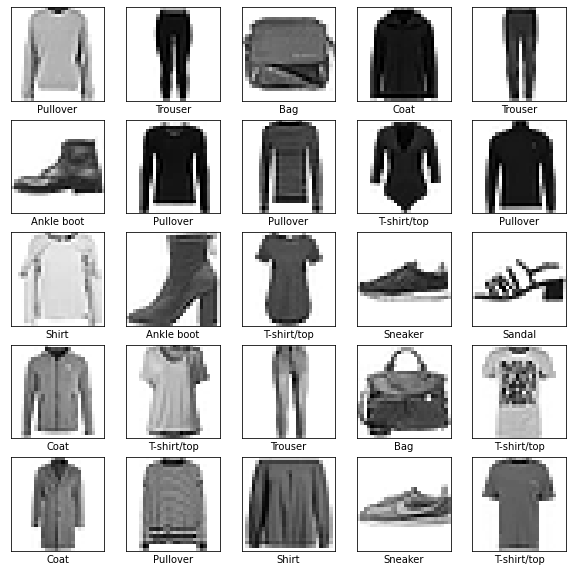

In [3]:
plt.figure(figsize=(10,10))

# Displaying 25 random samples
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(train_images[i][:][:]), cmap=plt.cm.binary)
    plt.xlabel(fashion_classes[train_labels[i]])
plt.show()

#### Data augmentation
This method will increase the raw data by data augmentation of images. I added rotation, horizontal flip and fill mode. Feel free to change these settings.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defines the options for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

def image_augmentation(image, nb_of_augmentation):
    '''
    Generates new images bei augmentation
    image : raw image
    nb_augmentation: number of augmentations
    images: array with new images
    '''
    images = []
    image = image.reshape(1, img_height, img_width, channels)
    i = 0
    for x_batch in datagen.flow(image, batch_size=1):
        images.append(x_batch)
        i += 1
        if i >= nb_of_augmentation:
            # interrupt augmentation
            break
    return images

#### Preprocess data
Processing of raw images:
- Scaling pixels between 0.0-1.0 : 

    Data is normalalize and then it is feed to the network.

- Add augmentated images

    Augmented images are added to input images and label images array list.

In [5]:
import tensorflow as tf

def preprocess_data(images, targets, use_augmentation=False, nb_of_augmentation=1):
    """
    images: raw image
    targets: target label
    use_augmentation: True if augmentation should be used
    nb_of_augmentation: If use_augmentation=True, number of augmentations
    """
    X = []
    y = []
    for x_, y_ in zip(images, targets):
        
        # scaling pixels between 0.0-1.0
        x_ = x_ / 255.
        
        # data Augmentation
        if use_augmentation:
            argu_img = image_augmentation(x_, nb_of_augmentation)
            for a in argu_img:
                X.append(a.reshape(img_height, img_width, channels))
                y.append(y_)

        X.append(x_)
        y.append(y_)
    print('*Preprocessing completed: %i samples\n' % len(X))
    return np.array(X), tf.keras.utils.to_categorical(y)

In [6]:
X_train_shaped, y_train_shaped = preprocess_data(
    X_train, y_train, 
    use_augmentation=True, 
    nb_of_augmentation=nb_augmentation
)

X_test_shaped, y_test_shaped = preprocess_data(X_test,  y_test)

*Preprocessing completed: 240000 samples

*Preprocessing completed: 10000 samples



#### Model definition

How important is NN model ?**bold text**
Experimentation plays an important role along with the Optimization of the model.  

Here we have 3 different Neural Network Models and we will analyse, compare, and understand the evaluation along with the working of the networks.

In [7]:
def small_model():
    """
    Creates a simple sequential model
    """
    
    cnn = tf.keras.Sequential()
    
    cnn.add(tf.keras.layers.InputLayer(input_shape=(img_height,img_width,channels)))
    
    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(16, (4, 4), padding='same', activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.1))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(tf.keras.layers.Flatten())
    
    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(16, activation='relu'))
    
    cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    return cnn


def medium_model():
    """
    Creates a simple sequential model
    """
    
    cnn = tf.keras.Sequential()
    
    cnn.add(tf.keras.layers.InputLayer(input_shape=(img_height,img_width,channels)))
    
    # Normalization
    cnn.add(tf.keras.layers.BatchNormalization())
    
    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.1))
    
    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(tf.keras.layers.Flatten())

    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(256, activation='relu'))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.5))
    
    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(64, activation='relu'))
    
    # Normalization
    cnn.add(tf.keras.layers.BatchNormalization())

    cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    return cnn


def large_model():
    """
    Creates a simple sequential model
    """
    
    cnn = tf.keras.Sequential()
    
    cnn.add(tf.keras.layers.InputLayer(input_shape=(img_height,img_width,channels)))
    
    # Normalization
    cnn.add(tf.keras.layers.BatchNormalization())
    
    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.1))

    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.1))

    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(tf.keras.layers.Flatten())

    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(256, activation='relu'))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.5))
    
    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(128, activation='relu'))


    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(64, activation='relu'))
    
    # Normalization
    cnn.add(tf.keras.layers.BatchNormalization())

    cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    return cnn

# Here we will load all 3 models and compile them
model_small = small_model()
model_small.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

model_medium = medium_model()
model_medium.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

model_large = large_model()
model_large.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

#### TRAINING
Now we will train our models on the augmented dataset which we have pre-processed. 

Firstly we will split the dataset into train and validation and give it to our model training.

we have also added callbacks which act as an monitoring system while training and changes the parameter as per our need. By monitoring Validation Accuracy we can save the Best model i.e. if Val accuracy is improved then it will save the model after that iteration.

In [ ]:
from sklearn.model_selection import train_test_split


X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, 
                                                      y_train_shaped,
                                                      test_size=0.2,
                                                      random_state=42
                                                      )

# Small
model_small_history = model_small.fit(
    X_train_, y_train_,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1,
    validation_data=(X_val_, y_val_),
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                             patience=15, min_delta=0.001, verbose=1),
        tf.keras.callbacks.ModelCheckpoint('cnn_small.h5', monitor='val_accuracy', 
                                           verbose=1, save_best_only=True)
    ]
)

#  Medium
model_medium_history = model_medium.fit(
    X_train_, y_train_,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1,
    validation_data=(X_val_, y_val_),
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                             patience=15, min_delta=0.001, verbose=1),
        tf.keras.callbacks.ModelCheckpoint('cnn_medium.h5', monitor='val_accuracy', 
                                           verbose=1, save_best_only=True)
    ]
)

# Large
model_large_history = model_large.fit(
    X_train_, y_train_,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1,
    validation_data=(X_val_, y_val_),
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                             patience=15, min_delta=0.001, verbose=1),
        tf.keras.callbacks.ModelCheckpoint('cnn_large.h5', monitor='val_accuracy', 
                                           verbose=1, save_best_only=True)
    ]
)

Epoch 1/200
375/375 [==============================] - 10s 7ms/step - loss: 1.0560 - accuracy: 0.6396 - val_loss: 0.4621 - val_accuracy: 0.8365

Epoch 00001: val_accuracy improved from -inf to 0.83650, saving model to cnn_small.h5
Epoch 2/200
375/375 [==============================] - 2s 6ms/step - loss: 0.4387 - accuracy: 0.8461 - val_loss: 0.3813 - val_accuracy: 0.8669

Epoch 00002: val_accuracy improved from 0.83650 to 0.86694, saving model to cnn_small.h5
Epoch 3/200
375/375 [==============================] - 2s 6ms/step - loss: 0.3777 - accuracy: 0.8680 - val_loss: 0.3463 - val_accuracy: 0.8793

Epoch 00003: val_accuracy improved from 0.86694 to 0.87929, saving model to cnn_small.h5
Epoch 4/200
375/375 [==============================] - 2s 6ms/step - loss: 0.3467 - accuracy: 0.8773 - val_loss: 0.3266 - val_accuracy: 0.8849

Epoch 00004: val_accuracy improved from 0.87929 to 0.88485, saving model to cnn_small.h5
Epoch 5/200
375/375 [==============================] - 2s 6ms/step - l

In [ ]:
keras_file = '/content/drive/MyDrive/tf_train_fmnist/cnn_small.h5'
tf.keras.models.save_model(model_small, keras_file, include_optimizer=False)
print('Saved small model to:', keras_file)

keras_file = '/content/drive/MyDrive/tf_train_fmnist/cnn_medium.h5'
tf.keras.models.save_model(model_medium, keras_file, include_optimizer=False)
print('Saved medium model to:', keras_file)

keras_file = '/content/drive/MyDrive/tf_train_fmnist/cnn_large.h5'
tf.keras.models.save_model(model_large, keras_file, include_optimizer=False)
print('Saved large model to:', keras_file)

Saved small model to: /content/drive/MyDrive/tf_train_fmnist/cnn_small.h5
Saved medium model to: /content/drive/MyDrive/tf_train_fmnist/cnn_medium.h5
Saved large model to: /content/drive/MyDrive/tf_train_fmnist/cnn_large.h5


#### Evaluation
we will load and compile our all 3 models and evaluate them for understanding and analysing.

In [ ]:
model_small = small_model()
model_small.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

model_medium = medium_model()
model_medium.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

model_large = large_model()
model_large.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


model_small.load_weights('/content/drive/MyDrive/tf_train_fmnist/cnn_small.h5')

_, small_model_test_accuracy = model_small.evaluate(test_images_norm, tf.keras.utils.to_categorical(test_labels), verbose=0)
_, small_model_train_accuracy = model_small.evaluate(X_train_, y_train_, verbose=0)
_, small_model_val_accuracy = model_small.evaluate(X_val_, y_val_, verbose=0)
_, small_model_trainval_accuracy = model_small.evaluate(train_images_norm, tf.keras.utils.to_categorical(train_labels), verbose=0)


print('small train accuracy:\t\t', small_model_train_accuracy)
print('small val accuracy:\t\t', small_model_val_accuracy)
print('small trainval accuracy:\t', small_model_val_accuracy)
print('small test accuracy:\t\t', small_model_test_accuracy)


model_medium.load_weights('/content/drive/MyDrive/tf_train_fmnist/cnn_medium.h5')

_, medium_model_test_accuracy = model_medium.evaluate(test_images_norm, tf.keras.utils.to_categorical(test_labels), verbose=0)
_, medium_model_train_accuracy = model_medium.evaluate(X_train_, y_train_, verbose=0)
_, medium_model_val_accuracy = model_medium.evaluate(X_val_, y_val_, verbose=0)
_, medium_model_trainval_accuracy = model_medium.evaluate(train_images_norm, tf.keras.utils.to_categorical(train_labels), verbose=0)

print('medium train accuracy:\t\t', medium_model_train_accuracy)
print('medium val accuracy:\t\t', medium_model_val_accuracy)
print('medium trainval accuracy:\t', medium_model_val_accuracy)
print('medium test accuracy:\t\t', medium_model_test_accuracy)


model_large.load_weights('/content/drive/MyDrive/tf_train_fmnist/cnn_large.h5')

_, large_model_test_accuracy = model_large.evaluate(test_images_norm, tf.keras.utils.to_categorical(test_labels), verbose=0)
_, large_model_train_accuracy = model_large.evaluate(X_train_, y_train_, verbose=0)
_, large_model_val_accuracy = model_large.evaluate(X_val_, y_val_, verbose=0)
_, large_model_trainval_accuracy = model_large.evaluate(train_images_norm, tf.keras.utils.to_categorical(train_labels), verbose=0)

print('large train accuracy:\t\t', large_model_train_accuracy)
print('large val accuracy:\t\t', large_model_val_accuracy)
print('large trainval accuracy:\t', large_model_val_accuracy)
print('large test accuracy:\t\t', large_model_test_accuracy)

small train accuracy:		 0.9550104141235352
small val accuracy:		 0.9274374842643738
small trainval accuracy:	 0.9274374842643738
small test accuracy:		 0.9186000227928162
medium train accuracy:		 0.9976666569709778
medium val accuracy:		 0.9725208282470703
medium trainval accuracy:	 0.9725208282470703
medium test accuracy:		 0.9370999932289124
large train accuracy:		 0.9906353950500488
large val accuracy:		 0.957854151725769
large trainval accuracy:	 0.957854151725769
large test accuracy:		 0.9254000186920166


#### Model Output Visualization

we will plot the input images along with their predictions.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(fashion_classes[predicted_label],
                                100*np.max(predictions_array),
                                fashion_classes[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

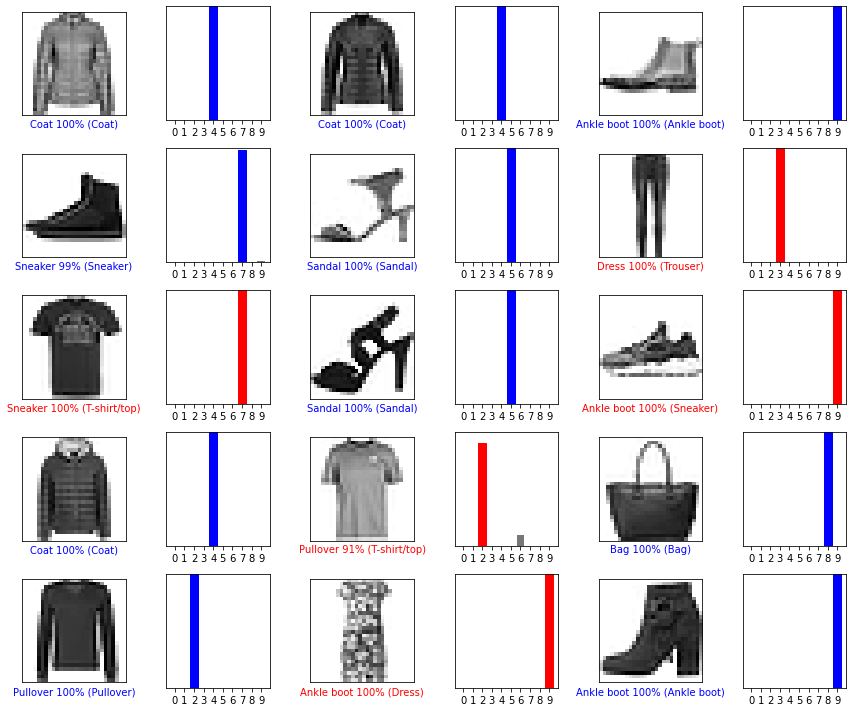

In [ ]:
predictions = model_medium.predict(test_images)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, np.squeeze(test_images))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [ ]:
import pickle
import glob
with open('/content/drive/MyDrive/tf_train_fmnist/history_small.pkl', 'wb') as f:
    pickle.dump(model_small_history.history, f)
with open('/content/drive/MyDrive/tf_train_fmnist/history_medium.pkl', 'wb') as f:
    pickle.dump(model_medium_history.history, f)
with open('/content/drive/MyDrive/tf_train_fmnist/history_large.pkl', 'wb') as f:
    pickle.dump(model_large_history.history, f)

list_files = glob.glob('/content/drive/MyDrive/tf_train_fmnist/history_*pkl')
with zipfile.ZipFile('history.zip', 'w') as zipMe:        
    for file in list_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)
files.download('/content/drive/MyDrive/tf_train_fmnist/history.zip')

In [10]:
import pickle
with open('/content/drive/MyDrive/tf_train_fmnist/history_small.pkl', 'rb') as f:   
    model_small_history = pickle.load(f) 
with open('/content/drive/MyDrive/tf_train_fmnist/history_medium.pkl', 'rb') as f:   
    model_medium_history = pickle.load(f) 
with open('/content/drive/MyDrive/tf_train_fmnist/history_large.pkl', 'rb') as f:   
    model_large_history = pickle.load(f) 

#### Plotting Accuracy and Loss 
For Small medium, large

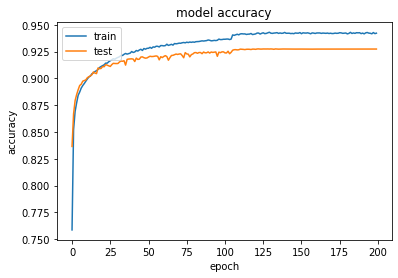

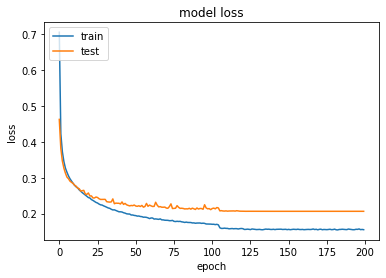

In [11]:
#  Small
history = model_small_history

# summarize history for loss
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

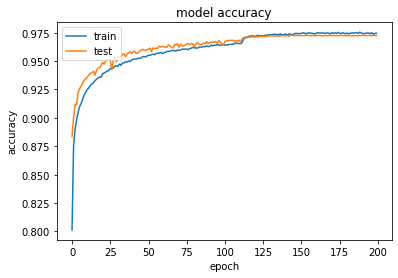

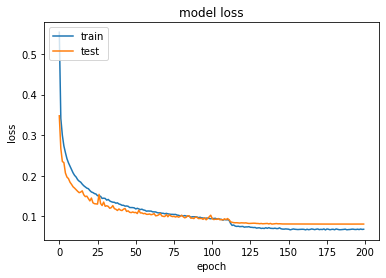

In [12]:
#  Medium
history = model_medium_history

# summarize history for loss
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

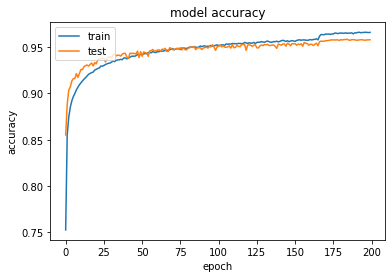

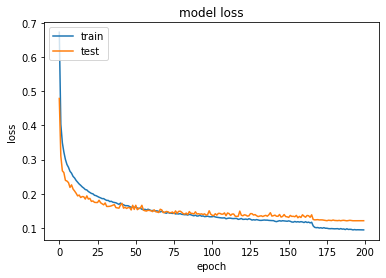

In [13]:
# Large
history = model_large_history

# summarize history for loss
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Pruning

Neural network pruning is a method of compression that involves removing weights from a trained model.
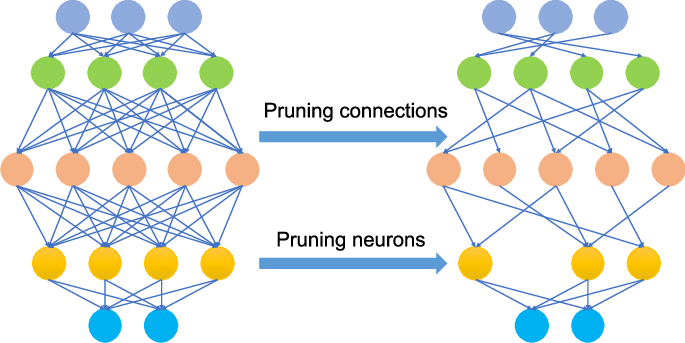

In [14]:
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot


model_medium = medium_model()
model_medium.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_medium.load_weights('/content/drive/MyDrive/tf_train_fmnist/cnn_medium.h5')

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

batch_size = 128
epochs = 200
validation_split = 0.2 # 20% of training set will be used for validation set. 

num_images = X_train_shaped.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.8,
                                                               begin_step=0,
                                                               frequency= 10,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model_medium, **pruning_params)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model_for_pruning.summary()

     |████████████████████████████████| 174kB 19.0MB/s 


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 28, 28, 1)         5         
_________________________________________________________________
prune_low_magnitude_conv2d_6 (None, 28, 28, 64)        2114      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 64)        1         
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 14, 14, 64)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_7 (None, 11, 11, 64)        131138    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 5, 5, 64)          1         
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 5, 5, 64)         

In [ ]:
from sklearn.model_selection import train_test_split


logdir = '/content/drive/MyDrive/tf_train_fmnist/cnn_pruning_logs/000'

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                                 patience=15, min_delta=0.001),
  tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/tf_train_fmnist/cnn_pruned_08.h5',
                                     monitor='val_accuracy', verbose=1, save_best_only=True)
  ]

X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped,
                                                        test_size=0.2, random_state=42)
model_pruning_history =model_for_pruning.fit(
    X_train_, y_train_,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1,
    validation_data=(X_val_, y_val_),
    callbacks=callbacks)

Epoch 1/200
   6/1500 [..............................] - ETA: 2:36 - loss: 6.5368 - accuracy: 0.1116WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0117s vs `on_train_batch_end` time: 0.0746s). Check your callbacks.


1500/1500 [==============================] - 37s 18ms/step - loss: 1.7164 - accuracy: 0.5574 - val_loss: 0.4087 - val_accuracy: 0.8482

Epoch 00001: val_accuracy improved from -inf to 0.84823, saving model to /content/drive/MyDrive/tf_train_fmnist/cnn_pruned_08.h5
Epoch 2/200
1500/1500 [==============================] - 27s 18ms/step - loss: 0.4996 - accuracy: 0.8173 - val_loss: 0.3074 - val_accuracy: 0.8879

Epoch 00002: val_accuracy improved from 0.84823 to 0.88788, saving model to /content/drive/MyDrive/tf_train_fmnist/cnn_pruned_08.h5
Epoch 3/200
1500/1500 [==============================] - 28s 19ms/step - loss: 0.3900 - accuracy: 0.8577 - val_loss: 0.2590 - val_accuracy: 0.9059

Epoch 00003: val_accuracy improved from 0.88788 to 0.90592, saving model to /content/drive/MyDrive/tf_train_fmnist/cnn_pruned_08.h5
Epoch 4/200
1500/1500 [==============================] - 28s 19ms/step - loss: 0.3510 - accuracy: 0.8722 - val_loss: 0.2383 - val_accuracy: 0.9132

Epoch 00004: val_accuracy i

In [ ]:
model_for_pruning.load_weights('/content/drive/MyDrive/tf_train_fmnist/cnn_pruned_08.h5')
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
_, pruned_medium_model_test_accuracy = model_for_export.evaluate(test_images_norm, tf.keras.utils.to_categorical(test_labels), verbose=0)
_, pruned_medium_model_train_accuracy = model_for_export.evaluate(X_train_, y_train_, verbose=0)
_, pruned_medium_model_val_accuracy = model_for_export.evaluate(X_val_, y_val_, verbose=0)
_, pruned_medium_model_trainval_accuracy = model_for_export.evaluate(train_images_norm, tf.keras.utils.to_categorical(train_labels), verbose=0)
print('medium train accuracy:\t\t', medium_model_train_accuracy)
print('medium val accuracy:\t\t', medium_model_val_accuracy)
print('medium trainval accuracy:\t', medium_model_val_accuracy)
print('medium test accuracy:\t\t', medium_model_test_accuracy)

print('pruned train accuracy:\t\t', pruned_medium_model_train_accuracy)
print('pruned val accuracy:\t\t', pruned_medium_model_val_accuracy)
print('pruned trainval accuracy:\t', pruned_medium_model_trainval_accuracy)
print('pruned test accuracy:\t\t', pruned_medium_model_test_accuracy)
keras_file = '/content/drive/MyDrive/tf_train_fmnist/cnn_pruned_exported.h5'
tf.keras.models.save_model(model_for_export, keras_file, include_optimizer=False)
print('Saved pruned model to:', keras_file)

In [ ]:
import os
import zipfile
import glob
h5s = glob.glob('/content/drive/MyDrive/tf_train_fmnist/cnn_*.h5')
for h5 in h5s:
    with zipfile.ZipFile(h5.split('.')[0]+'.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(h5)

In [ ]:
!ls -l --block-size=K /content/drive/MyDrive/tf_train_fmnist/*.zip